In [80]:
import json
songs = sc.textFile("s3n://stat-37601/new-songs.mp3.base64.json",minPartitions = 100).map(json.loads)

In [81]:
import base64
from io import BytesIO
import numpy as np
from pydub import AudioSegment
# convert a song data into samples in [-1, 1]
def audio_segment_to_samples(base64d_mp3d_song_data):
    mp3_buffer = BytesIO(base64.b64decode(base64d_mp3d_song_data))
    audio = AudioSegment.from_mp3(mp3_buffer)
    wave = audio.export('/tmp/buffer.wav', format='wav')
    wave.seek(0)
    return np.frombuffer(wave.read(), np.int16)[24:] / 2.**15

import matplotlib.mlab as mlab
from scipy.ndimage.filters import maximum_filter
# convert samples into a spectrogram and return peaks
def find_peaks(samples):
    ft_graph = mlab.specgram(samples, scale_by_freq=False)[0]
    # Don’t rescale by 1/f!
# add condition ft_graph!=0
    maxes = (maximum_filter(ft_graph, size=20) == ft_graph) & \
    (ft_graph > -150)&(ft_graph!=0)
    # Compute relative maxima 20 units away from others, where
    # intensity is greater than -150 dB.
    freqs, times = np.where(maxes)
    return (freqs, times)

import hashlib
def hash_two_close_peaks(time1, freq1, time2, freq2,reduction=0):
    return hashlib.sha1("{}:{}:{}".format(time2 - time1, freq2, freq1)).hexdigest()[:(40-reduction)]


# a. Processing songs. Compute the number of peaks for each song, and print out the average. Then, plot the number of fingerprints per song in a bar chart.

In [82]:
array_sample=songs.map(lambda x:(x["song_id"],audio_segment_to_samples(x["data"])))

In [13]:
array_sample.take(1)

[(0, array([  0.00000000e+00,   0.00000000e+00,  -3.05175781e-05, ...,
          -8.85009766e-04,  -1.22070312e-04,  -4.88281250e-04]))]

In [83]:
peaks=array_sample.map(lambda x: (x[0],find_peaks(x[1])))

In [84]:
import time
ptm=time.time()
peaks_number=peaks.map(lambda x: (x[0],len(x[1][0]))).reduceByKey(lambda a,b:a+b).collect()
t_used=time.time()-ptm
print "time used for counting number of peaks %s s" %t_used

time used for counting number of peaks 131.570552826 s


Here, peaks_number is a list of tuples. Change the list of tuples into a dictionary, making it more convenient to extract the song_id and the count values.

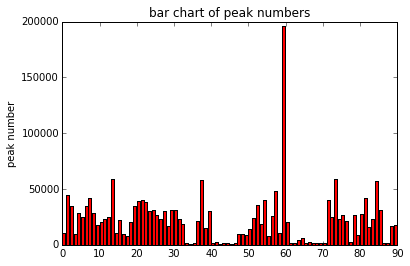

In [85]:
peak_number_dic=dict(peaks_number)
import matplotlib.pyplot as plt
%matplotlib inline 
p1 = plt.bar(peak_number_dic.keys(), peak_number_dic.values(), color='r')
plt.ylabel('peak number')
plt.title('bar chart of peak numbers')

In [86]:
avg_peak=np.average(peak_number_dic.values())
print "average peak number per song is %s" %avg_peak

average peak number per song is 22118.4666667


# b. Hashing

First, sort the tuples by sequence of time

In [87]:
peaks_sorted=peaks.map(lambda x: (x[0],sorted(zip(x[1][1],x[1][0]))))

In [88]:
def hashed_pairs(x,r):
    hashed=[]
    tuples=x[1]
    idx=x[0]
    s=1
    N=len(tuples)
    for i in range(0,N-1):
        for j in range(s,N):
            if tuples[j][0]-tuples[i][0]>200:
                break
        s=j
        for k in range(i+1,s):
            pair=hash_two_close_peaks(tuples[i][0], tuples[i][1], tuples[k][0], tuples[k][1] ,reduction=r)
            hashed.append((idx,pair))
    return hashed

In [129]:
import time
ptm=time.time()
hashed_pair_peak=peaks_sorted.flatMap(lambda x: hashed_pairs(x,0))
hash_counts=hashed_pair_peak.map(lambda x: (x[0],1)).reduceByKey(lambda a, b: a + b).collect()
time_used=time.time()-ptm

print "time used for counting is %s s" %time_used

time used for counting is 345.140414 s


In [32]:
hashed_pair_peak.take(1)

[(0, 'bcd302010fc308fa5d52a1407ad9e4e89b091118')]

In [130]:
hash_counts

[(0, 283726),
 (1, 1700699),
 (2, 1227684),
 (3, 243994),
 (4, 882018),
 (5, 801217),
 (6, 1058949),
 (7, 1378221),
 (8, 802561),
 (9, 665906),
 (10, 669569),
 (11, 835173),
 (12, 1070820),
 (13, 1908833),
 (14, 344915),
 (15, 833475),
 (16, 313606),
 (17, 275059),
 (18, 661109),
 (19, 1058949),
 (20, 1172676),
 (21, 1268611),
 (22, 1153200),
 (23, 864014),
 (24, 988354),
 (25, 828199),
 (26, 787241),
 (27, 1197972),
 (28, 660150),
 (29, 1152030),
 (30, 1129807),
 (31, 812156),
 (32, 708532),
 (33, 47419),
 (34, 35309),
 (35, 51848),
 (36, 775402),
 (37, 2018945),
 (38, 562832),
 (39, 1064849),
 (40, 25175),
 (41, 86624),
 (42, 34746),
 (43, 43046),
 (44, 34154),
 (45, 20817),
 (46, 58175),
 (47, 290043),
 (48, 352886),
 (49, 242169),
 (50, 478755),
 (51, 1029740),
 (52, 1378077),
 (53, 697833),
 (54, 1749035),
 (55, 229747),
 (56, 706399),
 (57, 1389329),
 (58, 319487),
 (59, 6450190),
 (60, 484735),
 (61, 33468),
 (62, 71311),
 (63, 151450),
 (64, 244431),
 (65, 66427),
 (66, 90618),

In [ ]:
import time
counts=[]
counts.append(hashed_counts)
t=[]
t.append(time_used)
for r in range(1,6):
    ptm=time.time()
    hashed_pair_peak=peaks_sorted.flatMap(lambda x: hashed_pairs(x,2*r))
    hash_counts=hashed_pair_peak.map(lambda x: (x[0],1)).reduceByKey(lambda a, b: a + b).collect()
    time_used=time.time()-ptm
    counts.append(hashed_counts)
    t.append(time_used)


The program runs faster as r goes up, and number of hashes within a song generally goes down.

# c. Common Peaks

In [131]:
hashed_pair_peak=peaks_sorted.flatMap(lambda x: hashed_pairs(x,0))
grouped_hash=hashed_pair_peak.map(lambda x: (x[1],x[0])).groupByKey()
grouped_hash_list=grouped_hash.map(lambda x: (x[0], list(x[1])))

In [132]:
grouped_hash_list.take(1)

[('ac8caba871ad0921f27bb513776396ec0577d799', [33, 24])]

In [133]:
dic_pair={}
for i in range(0,89):
    if i<88:
        for j in range(i+1,90):
            pair=(i,j)
            dic_pair[pair]=0
    else:
        pair=(88,89)
        dic_pair[pair]=0
        


In [134]:
import itertools
def generate_pairs(x):
    d={}
    for j in x:
        d[j]=0
    thelist=[]
    for a,b in itertools.combinations(d,2):
        thelist.append((a,b))
    return thelist

In [139]:
generate_pairs(a)

[(3, 1), (3, 2), (3, 11), (1, 2), (1, 11), (2, 11)]

In [145]:
def count_pairs(dic,x):
    for k in dic.keys():
        dic[k]=0
    for p in x:
        if p[0]>p[1]:
            p=(p[1],p[0])
            dic[p]=1
        else:
            dic[p]=1
    return dic    

In [146]:
import math
def add_dic(x,y):
    d={}
    for k in dic_pair:
        d[k]=x[k]+y[k]
    return d


In [147]:
grouped_hash_pair_songs=grouped_hash_list.map(lambda x: (x[0],generate_pairs(x[1])))
hash_pair_count=grouped_hash_pair_songs.map(lambda x: count_pairs(dic_pair,x[1])).reduce(lambda a,b: add_dic(a,b))

In [235]:
import operator
sorted_counts = sorted(hash_pair_count.items(), key=operator.itemgetter(1), reverse=True)
sorted_counts

[((59, 73), 2926139),
 ((59, 84), 2863243),
 ((31, 59), 2219124),
 ((59, 81), 2210899),
 ((6, 19), 1907292),
 ((30, 59), 1892093),
 ((27, 59), 1841220),
 ((59, 72), 1746726),
 ((59, 80), 1668987),
 ((59, 83), 1619081),
 ((29, 59), 1525804),
 ((24, 37), 1522303),
 ((74, 83), 1521223),
 ((59, 75), 1455710),
 ((59, 82), 1429367),
 ((15, 37), 1425288),
 ((54, 73), 1368754),
 ((59, 74), 1340244),
 ((59, 71), 1332227),
 ((54, 84), 1282833),
 ((37, 59), 1269268),
 ((13, 73), 1260047),
 ((21, 73), 1250156),
 ((28, 59), 1236521),
 ((57, 84), 1233263),
 ((57, 73), 1225365),
 ((31, 84), 1223594),
 ((29, 84), 1187243),
 ((54, 59), 1174061),
 ((37, 64), 1162667),
 ((30, 73), 1161268),
 ((10, 37), 1160275),
 ((30, 84), 1124430),
 ((52, 84), 1099285),
 ((59, 78), 1087625),
 ((22, 84), 1086241),
 ((20, 73), 1077653),
 ((29, 81), 1076999),
 ((59, 76), 1075872),
 ((24, 81), 1069383),
 ((21, 84), 1043381),
 ((19, 73), 1037580),
 ((24, 84), 1035003),
 ((29, 37), 1032151),
 ((22, 51), 1024014),
 ((51, 73),

In [ ]:
import math
hash_norm_count={}
for k in hash_pair_count.keys():
    hash_norm_count[k]=math.log(hash_pair_count[k])-math.log(max(hash_counts[k[0]][1],hash_counts[k[1]][1]))
   

In [173]:
import operator
sorted_hash_norm_count=sorted(hash_norm_count.items(), key=operator.itemgetter(1), reverse=True)
sorted_hash_norm_count

[((74, 83), -0.8685408245945947),
 ((6, 19), -1.2473336568188547),
 ((51, 53), -1.7031867813713504),
 ((55, 64), -1.740271046782496),
 ((47, 48), -1.7416755114052922),
 ((44, 70), -1.7734959911950163),
 ((28, 53), -1.7949415044093318),
 ((32, 53), -1.8001498740770003),
 ((12, 51), -1.820377099673527),
 ((48, 50), -1.8204724344727836),
 ((47, 50), -1.83237000006641),
 ((47, 49), -1.85073569501494),
 ((9, 53), -1.8928962904418825),
 ((62, 65), -1.8955926359401083),
 ((53, 74), -1.897325449093028),
 ((53, 83), -1.897325449093028),
 ((51, 72), -1.8982665622839985),
 ((14, 58), -1.911629252189032),
 ((53, 82), -1.9122416315674897),
 ((53, 72), -1.9290865172350138),
 ((15, 51), -1.931713614507915),
 ((51, 80), -1.9361237328674203),
 ((9, 28), -1.9361755232012214),
 ((14, 79), -1.941982844195417),
 ((25, 53), -1.945041170448711),
 ((22, 51), -1.9461946154572392),
 ((1, 54), -1.9550614898526302),
 ((15, 25), -1.9740759868913607),
 ((51, 54), -1.9746349705114472),
 ((6, 51), -1.9766288674803434

In [228]:
import numpy as np
count_data=np.zeros((90,90))
for k in hash_pair_count.keys():
    count_data[k[0],k[1]]=hash_norm_count[k]
    count_data[k[1],k[0]]=hash_norm_count[k]

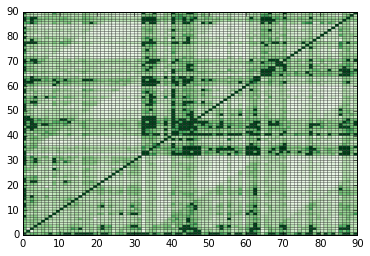

In [230]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.pcolor(count_data,cmap=plt.cm.Greens,edgecolor='k')
#plt.xticks(np.arange(0,90))
#plt.yticks(np.arange(0,90))
plt.show()
plt.close()

In [164]:
def audio_segment_in_ipython(song_data):
    from IPython.core.display import HTML, display
    display(HTML("""<audio controls="controls" style="width:600px" >
        <source controls
            src="data:audio/mp3;base64,{}" type="audio/mp3" />
      </audio>""".format(song_data)))

In [167]:
def play_song(idx):
    song = songs.filter(lambda x: x["song_id"] == idx).collect()
    sounds= map((lambda x: AudioSegment.from_mp3(BytesIO(base64.b64decode(x["data"])))), song)
    overall_sound = reduce(lambda a, b: a + b, sounds)
    overall_sound.export('test.mp3', format='mp3') 
    return audio_segment_in_ipython(base64.b64encode(open("test.mp3").read()))

#74,83 are identical; 6 and 19 are identical.